# Using the Stochastic Processes in QuickSig

QuickSig contains several stochastic processes, including
1. Brownian motion
2. Fractional Brownian motion
3. The Riemann-Liouville process

In this demo, we will work with the Riemann-Liouville process, an early approximation of the fractional Brownian motion which shows positive or negative autocorrelation depending on the `hurst` parameter. 

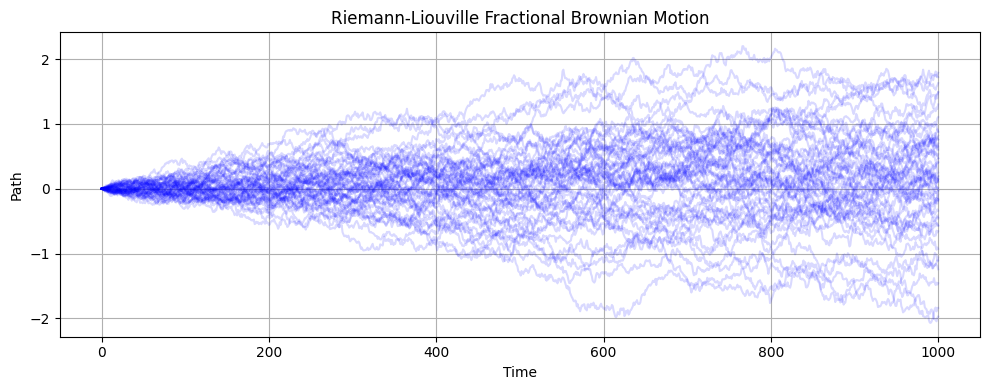

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from quicksig.rdes import drivers

key = jax.random.key(1)
num_paths = 50
timesteps = 1000

keys = jax.random.split(key, num_paths)
paths = []
for k in keys:
    bm = drivers.bm_driver(k, timesteps=timesteps, dim=1)
    path = drivers.riemann_liouville_driver(k, timesteps=timesteps, hurst=0.75, bm_path=bm)
    paths.append(path.squeeze())

plt.figure(figsize=(10, 4))
for path in paths:
    plt.plot(path, color="blue", alpha=0.15)
plt.title("Riemann-Liouville Fractional Brownian Motion")
plt.xlabel("Time")
plt.ylabel("Path")
plt.grid(True)
plt.tight_layout()
plt.show()

# Augmentations

## Windows
Before forming the signature of this rough path, we may first wish to divide it into subsections to make it easier to work with computationally.

Let's form some `non_overlapping_windows`

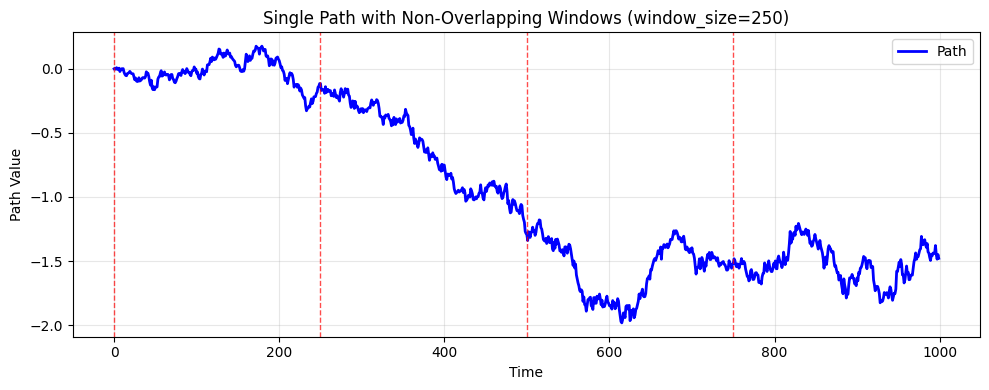


Window details:
Window 0: indices 0-249, length 250
Window 1: indices 250-499, length 250
Window 2: indices 500-749, length 250
Window 3: indices 750-999, length 250


In [ ]:
import functools
from quicksig.rde import augmentations

# Get the first path and reshape to 2D
single_path = paths[0][:1000].reshape(-1, 1)  # Reshape to (n_points, 1) for 2D array

# Create non-overlapping windows with window size 250
window_size = 250
non_overlapping_windower_func = functools.partial(
    augmentations.non_overlapping_windower, window_size=window_size
)
windows = non_overlapping_windower_func(single_path)

# Plot the single path with window boundaries
plt.figure(figsize=(10, 4))
plt.plot(single_path, color="blue", linewidth=2, label="Path")

# Draw vertical lines for window boundaries
for i in range(len(windows)):
    boundary_position = i * window_size
    if boundary_position < len(single_path):
        plt.axvline(x=boundary_position, color="red", linestyle="--", alpha=0.7, linewidth=1)

# Draw the final boundary if there's a remainder
if len(single_path) % window_size != 0:
    final_boundary = (len(windows) - 1) * window_size + len(windows[-1])
    plt.axvline(x=final_boundary, color="red", linestyle="--", alpha=0.7, linewidth=1)

plt.title(f"Single Path with Non-Overlapping Windows (window_size={window_size})")
plt.xlabel("Time")
plt.ylabel("Path Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print window information
print("\nWindow details:")
for i, window in enumerate(windows):
    start_idx = i * window_size
    end_idx = start_idx + len(window)
    print(f"Window {i}: indices {start_idx}-{end_idx - 1}, length {len(window)}")

## Composing windows
We can also compose windowing types. Lets take `non_overlapping_windows` over the whole time series, and form `dyadic_windows` of `depth = 2` within each non-overlapping window

=== Using augment_path with Combined Windowers ===
Original path shape: (1000, 1)
Number of non-overlapping windows: 4
Each non-overlapping window contains dyadic windowing info for depths 0 to 2

Non-Overlapping Window 0:
  Depth 0: 1 dyadic windows
    Window lengths: [250]
  Depth 1: 2 dyadic windows
    Window lengths: [125 125]
  Depth 2: 4 dyadic windows
    Window lengths: [62 63 62 63]

Non-Overlapping Window 1:
  Depth 0: 1 dyadic windows
    Window lengths: [250]
  Depth 1: 2 dyadic windows
    Window lengths: [125 125]
  Depth 2: 4 dyadic windows
    Window lengths: [62 63 62 63]

Non-Overlapping Window 2:
  Depth 0: 1 dyadic windows
    Window lengths: [250]
  Depth 1: 2 dyadic windows
    Window lengths: [125 125]
  Depth 2: 4 dyadic windows
    Window lengths: [62 63 62 63]

Non-Overlapping Window 3:
  Depth 0: 1 dyadic windows
    Window lengths: [250]
  Depth 1: 2 dyadic windows
    Window lengths: [125 125]
  Depth 2: 4 dyadic windows
    Window lengths: [62 63 62 63]


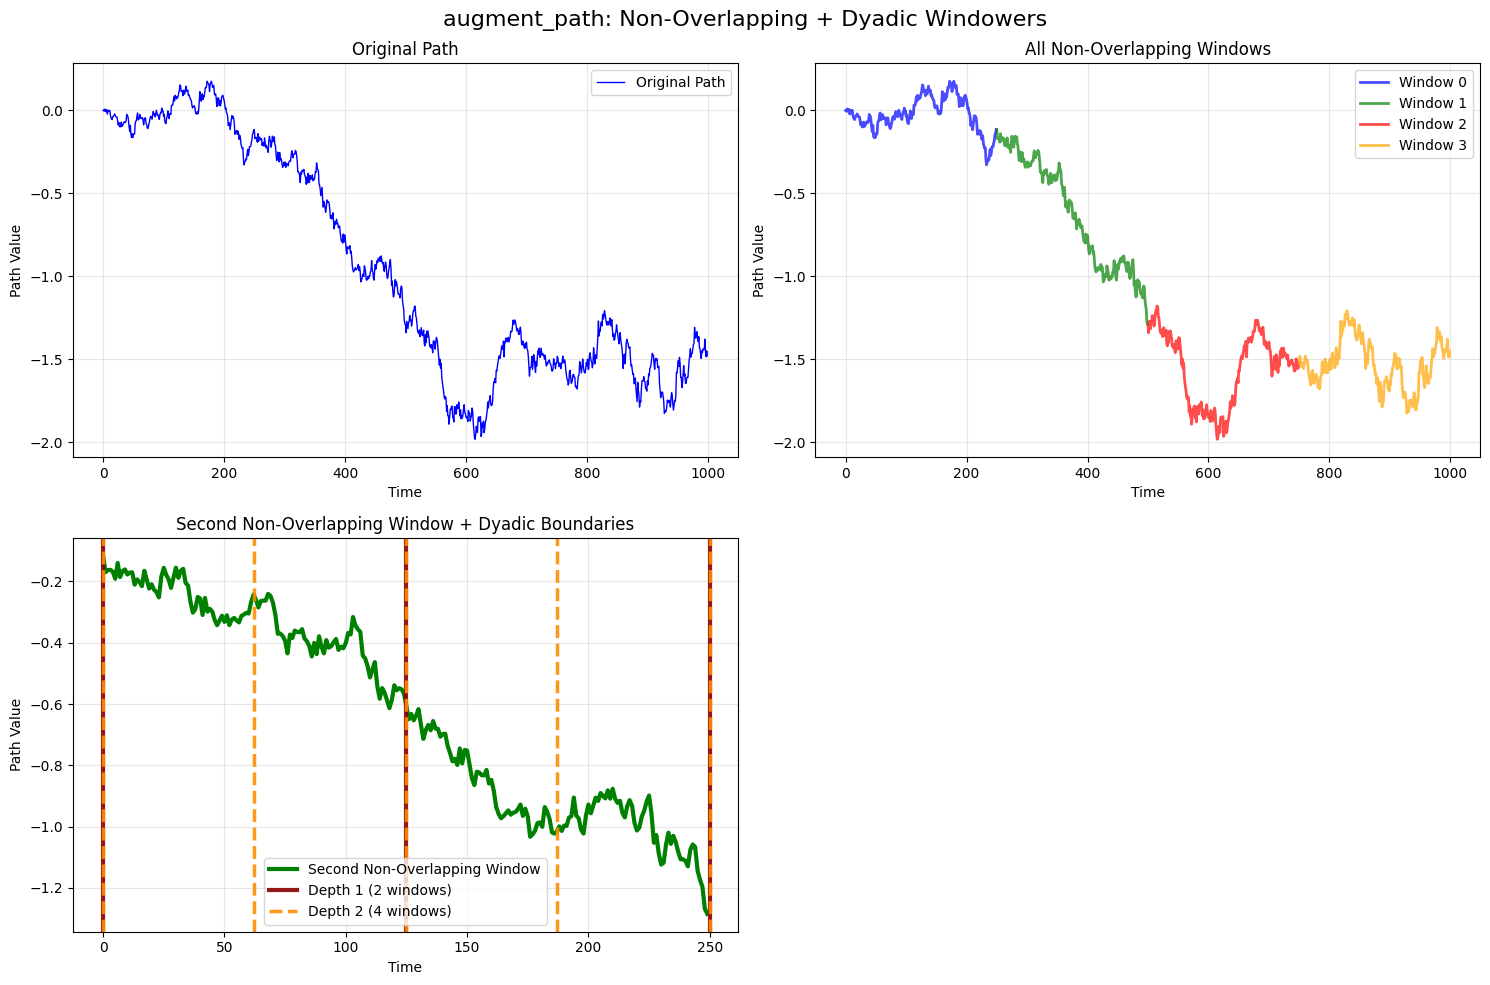


Result structure: List of 4 non-overlapping windows
Each non-overlapping window contains dyadic info for depths 0-2
This demonstrates the power of augment_path for composing windowing operations!


In [ ]:
# Using augment_path with non-overlapping and dyadic windowers

print("=== Using augment_path with Combined Windowers ===")

# Get the first path and reshape to 2D
single_path = paths[0][:1000].reshape(-1, 1)
print(f"Original path shape: {single_path.shape}")

# Create partial functions for non-overlapping and dyadic windowers
window_size = 250
window_depth = 2

non_overlapping_partial = functools.partial(
    augmentations.non_overlapping_windower, window_size=window_size
)
dyadic_partial = functools.partial(augmentations.dyadic_windower, window_depth=window_depth)

# Use augment_path with both windowers
augmentations_list = [non_overlapping_partial, dyadic_partial]
combined_result = augmentations.augment_path(single_path, augmentations_list)

print(f"Number of non-overlapping windows: {len(combined_result)}")
print(f"Each non-overlapping window contains dyadic windowing info for depths 0 to {window_depth}")

# Analyze the structure
for i, dyadic_info in enumerate(combined_result):
    print(f"\nNon-Overlapping Window {i}:")
    for depth, (padded_windows, window_lengths) in enumerate(dyadic_info):
        print(f"  Depth {depth}: {len(padded_windows)} dyadic windows")
        print(f"    Window lengths: {window_lengths}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("augment_path: Non-Overlapping + Dyadic Windowers", fontsize=16)

# Plot 1: Original path
ax1 = axes[0, 0]
ax1.plot(single_path, color="blue", linewidth=1, label="Original Path")
ax1.set_title("Original Path")
ax1.set_xlabel("Time")
ax1.set_ylabel("Path Value")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Show all non-overlapping windows
ax2 = axes[0, 1]
colors = ["blue", "green", "red", "orange", "purple"]
for i, dyadic_info in enumerate(combined_result):
    # Get the full window from depth 0
    window_full = dyadic_info[0][0][0]  # Depth 0, first window
    window_length = dyadic_info[0][1][0]  # Actual length
    window = window_full[:window_length]

    color = colors[i % len(colors)]
    time_offset = i * window_size
    time_indices = jnp.arange(len(window)) + time_offset
    ax2.plot(time_indices, window, color=color, linewidth=2, alpha=0.7, label=f"Window {i}")

ax2.set_title("All Non-Overlapping Windows")
ax2.set_xlabel("Time")
ax2.set_ylabel("Path Value")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Second non-overlapping window with dyadic boundaries
ax3 = axes[1, 0]
# Reconstruct the second non-overlapping window from dyadic info
second_dyadic_info = combined_result[1]  # Second window (green)
second_window_full = second_dyadic_info[0][0][0]  # Depth 0, first (and only) window
# Remove padding by using the actual length
second_window_length = second_dyadic_info[0][1][0]  # Depth 0, length of second window
second_window = second_window_full[:second_window_length]

ax3.plot(second_window, color="green", linewidth=3, label="Second Non-Overlapping Window")

# Add dyadic boundaries for all depths with clearer lines
depth_colors = ["darkred", "darkorange", "darkred"]
depth_styles = ["-", "--", ":"]
depth_widths = [3, 2.5, 2]
for depth in range(1, len(second_dyadic_info)):  # Skip depth 0
    padded_windows, window_lengths = second_dyadic_info[depth]
    color = depth_colors[(depth - 1) % len(depth_colors)]
    style = depth_styles[(depth - 1) % len(depth_styles)]
    width = depth_widths[(depth - 1) % len(depth_widths)]
    num_windows = len(padded_windows)

    boundaries = jnp.floor(jnp.linspace(0, len(second_window), num_windows + 1)).astype(int)
    for i, boundary in enumerate(boundaries):
        ax3.axvline(
            x=boundary,
            color=color,
            linestyle=style,
            alpha=0.9,
            linewidth=width,
            label=f"Depth {depth} ({2**depth} windows)" if i == 0 else "",
        )

ax3.set_title("Second Non-Overlapping Window + Dyadic Boundaries")
ax3.set_xlabel("Time")
ax3.set_ylabel("Path Value")
ax3.legend()
ax3.grid(True, alpha=0.3)

# Hide the fourth subplot
axes[1, 1].axis("off")


plt.tight_layout()
plt.show()

print(f"\nResult structure: List of {len(combined_result)} non-overlapping windows")
print(f"Each non-overlapping window contains dyadic info for depths 0-{window_depth}")
print("This demonstrates the power of augment_path for composing windowing operations!")